In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
import pickle
import os

import numpy as np
import pandas as pd

from scipy import signal

import mne
from matplotlib import pyplot as plt

import constants
import dataset
import folders
import iter_topography_fork
import analysis_and_plotting_functions as aps


In [2]:
plt.rcParams['figure.figsize'] = [15,7]
plt.rcParams.update({'font.size': 8})

In [3]:
# # Create dataset from raw data
# # Run this cell once if not 
# # Important -- deletes all contents of database_path
# dataset.EpDatasetCreator(markup_path=folders.markup_path,
#                         database_path=folders.database_path,
#                         data_folder=folders.data_folder,
#                         reference_mode='average', 
#                         ICA=True,
#                         fit_with_additional_lowpass=True
#                         )

In [4]:
# Load dataset into memory (if short of memory, use preload=False)
ds = dataset.DatasetReader(data_path=folders.database_path, preload=True)

100 percent complete

Plot grand average waveforms for large stimuli, blind vs sighted.
Default preprocessing parameters: CAR reference + 1-35 bandoass filter + 50 ms pre-stimulus baseline correction
Vertical dashed lines denote 0, 100  and 300 ms.
The BCI mode can be changed by changing `reg` variable

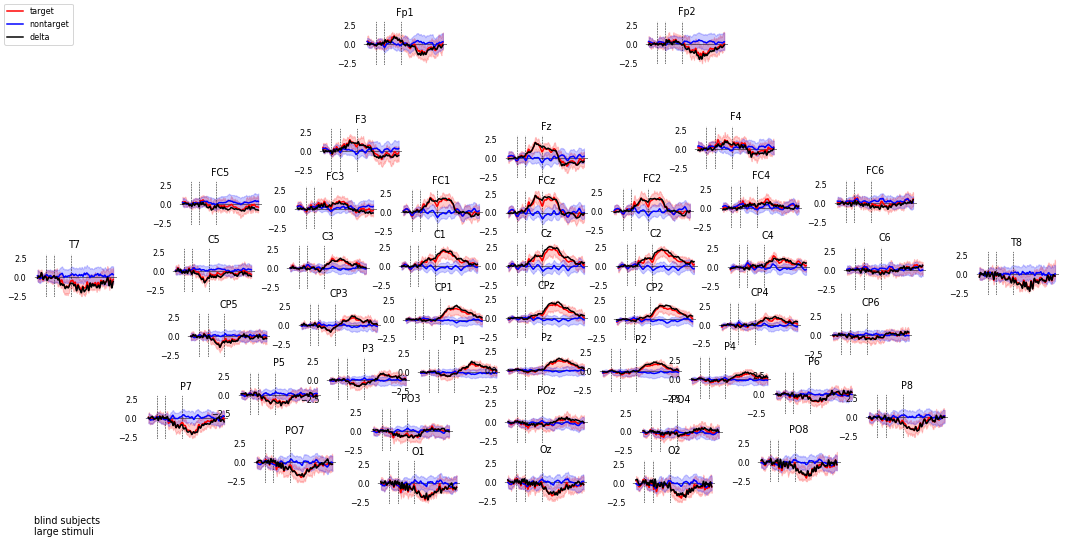

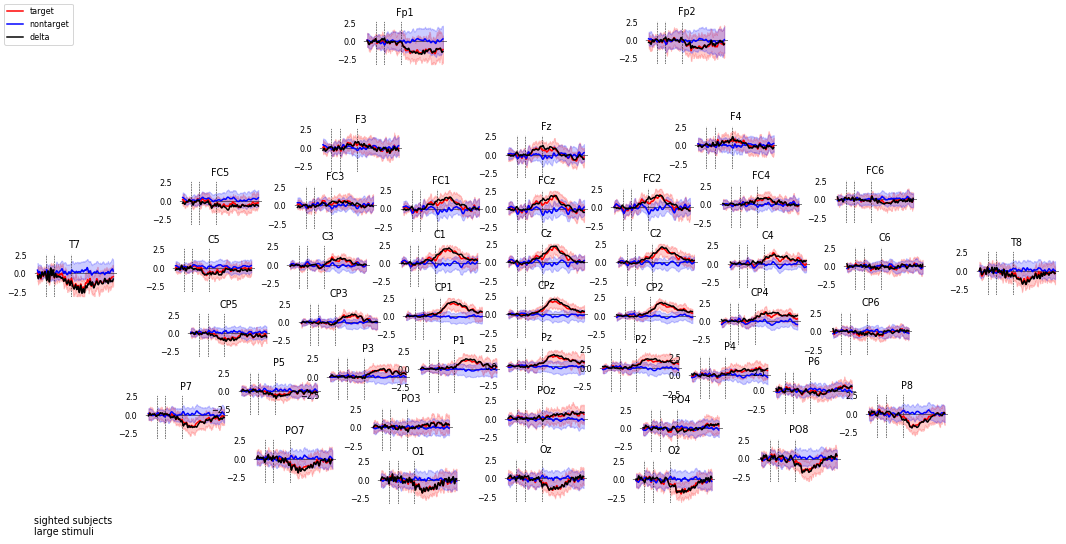

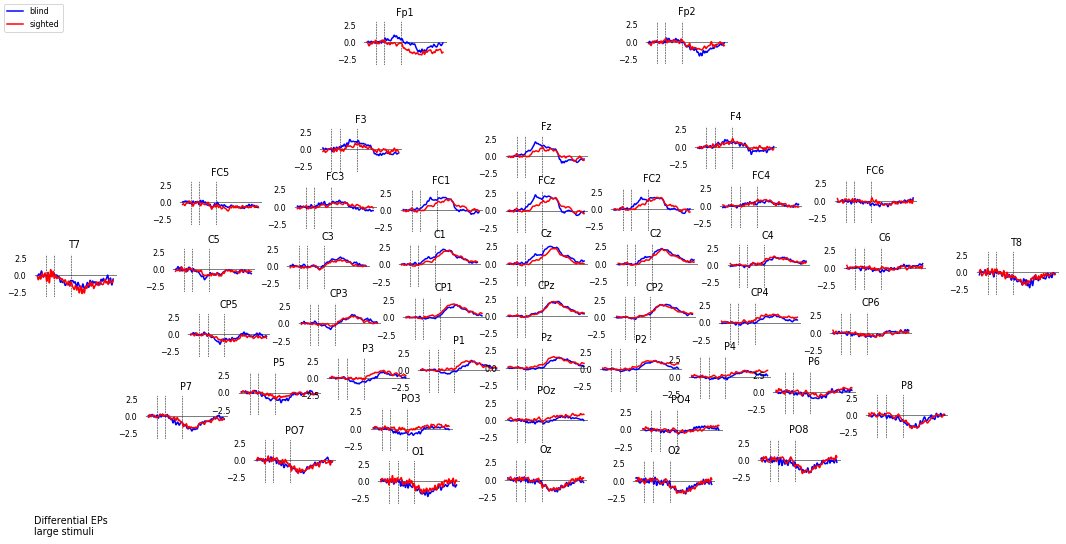

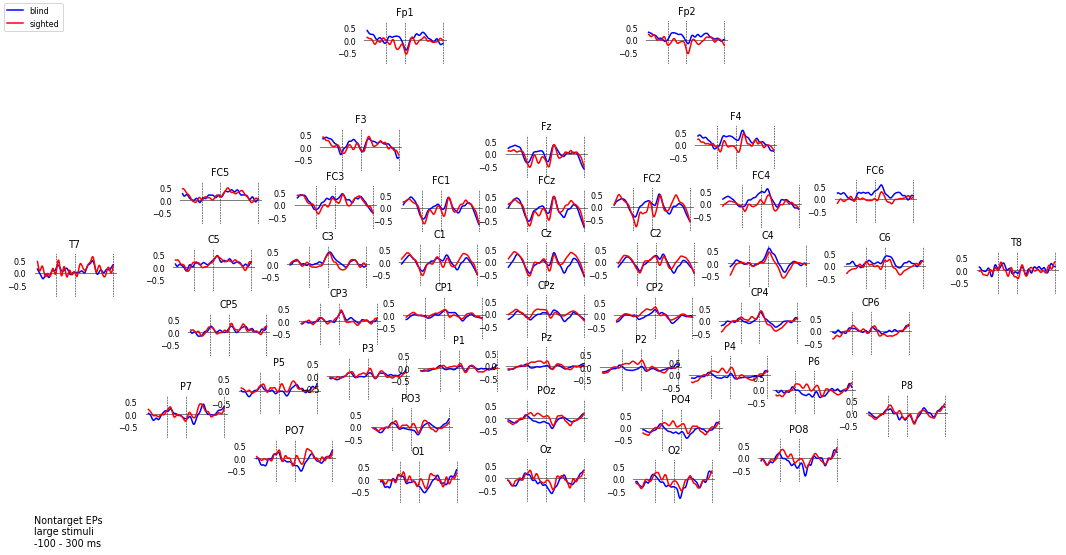

C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


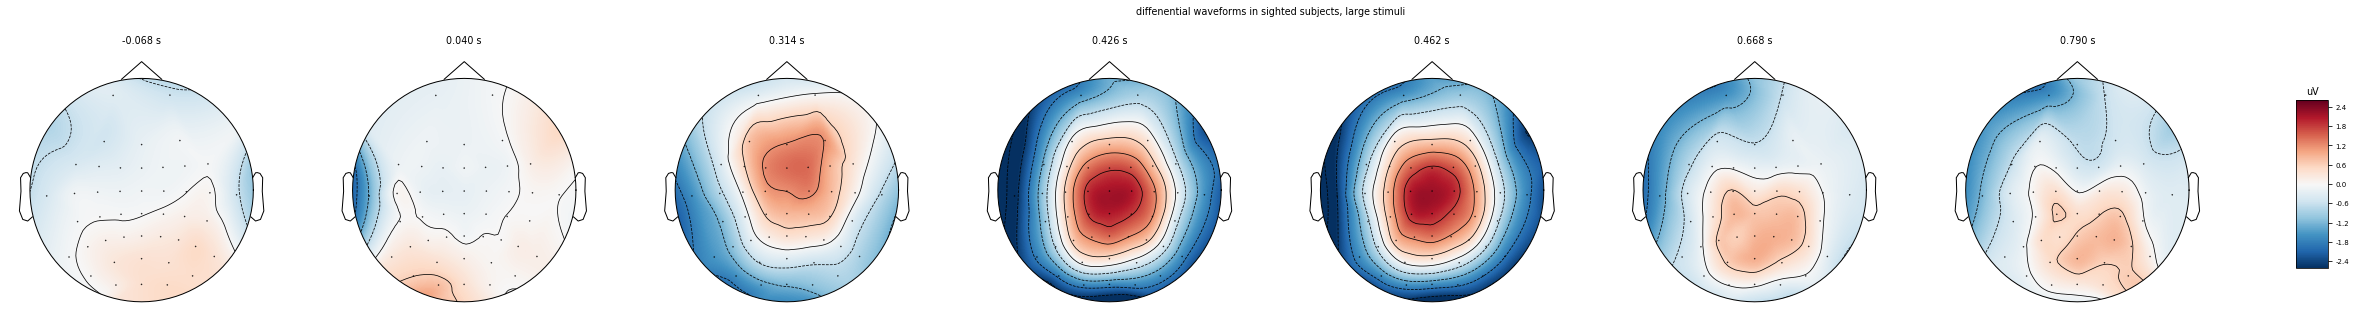

In [5]:
reg = 'large'

subset_blind = ds.markup.loc[ (ds.markup['blind'] == 1) &
                              (ds.markup['reg'] == reg) &
                              (ds.markup.leading_hand =='r')]
subset_sighted = ds.markup.loc[ (ds.markup['blind'] == 0) &
                                (ds.markup['reg'] == reg) &
                                (ds.markup.leading_hand =='r')]

evoked_blind = aps.subset(ds, subset_blind, quantiles=[0.450, 0.550])
evoked_sighted = aps.subset(ds, subset_sighted, quantiles=[0.450, 0.550])


aps.plot_evoked_response(evoked_dict=evoked_blind, 
                         title=f'blind subjects\nlarge stimuli')
aps.plot_evoked_response(evoked_dict=evoked_sighted, 
                         title=f'sighted subjects\nlarge stimuli')
aps.plot_evoked_response(evoked_dict = {'blind': evoked_blind['delta'],
                                        'sighted': evoked_sighted['delta']},
                         title=f'Differential EPs\n{reg} stimuli')

   
aps.plot_evoked_response(evoked_dict = {'blind': evoked_blind['nontarget'].crop(tmax=0.3),
                                        'sighted': evoked_sighted['nontarget'].crop(tmax=0.3)},
                         title=f'Nontarget EPs\n{reg} stimuli\n-100 - 300 ms')

p = evoked_sighted['delta'].plot_topomap(times='peaks', scalings={'eeg':1}, show=False, contours=8, size=3)
p.suptitle(f'diffenential waveforms in sighted subjects, {reg} stimuli')
p.show()

Plot grand average event-related potentials for right and left hand.

Target ERP don't differ much, but non-target EPs have inverse symmetrical peak location. This is the predicted outcome, because non-target EPs are not cognitive (at least, their cognitive component is not very pronounced), and exhibit contralateral somatotopy.

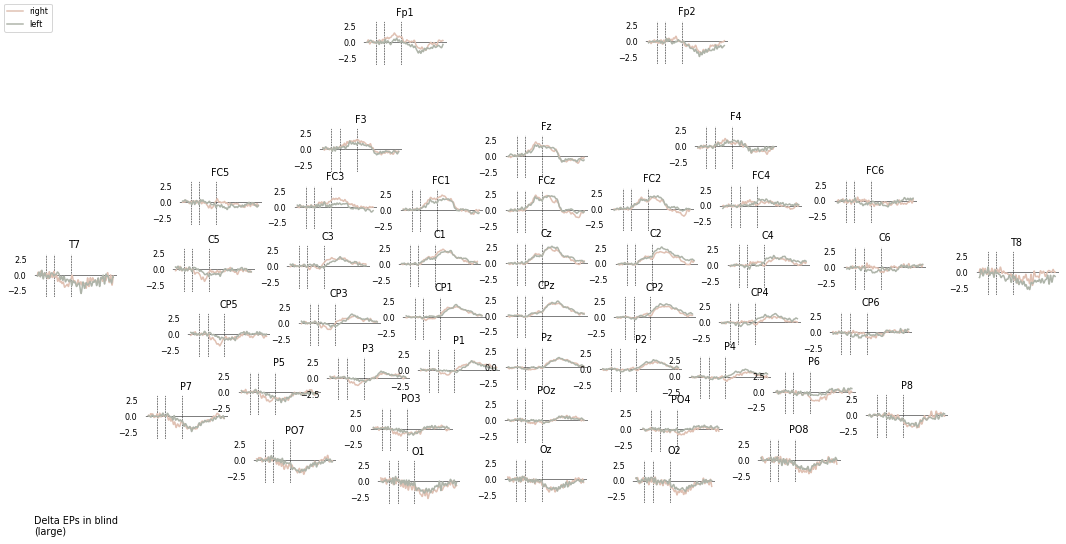

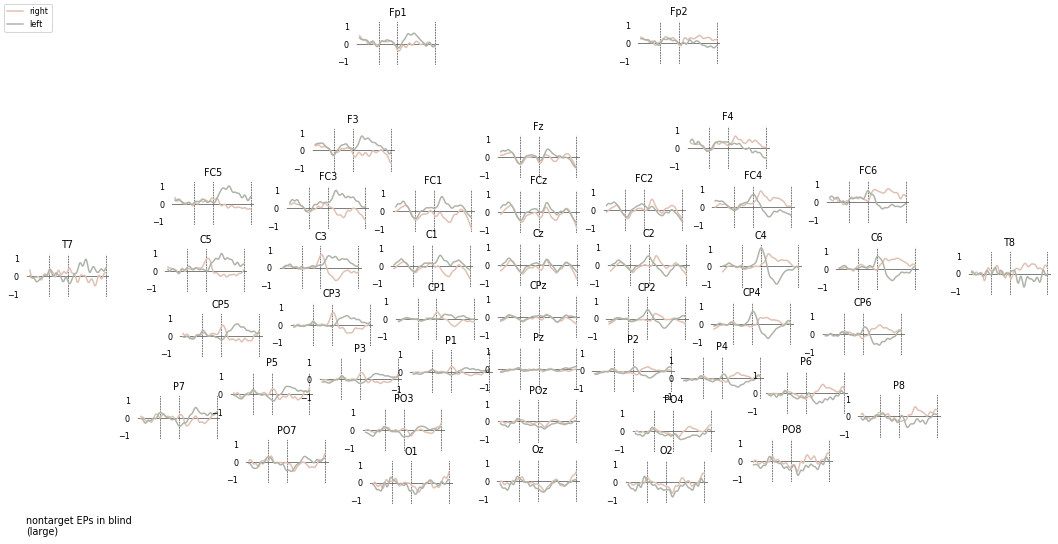

C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


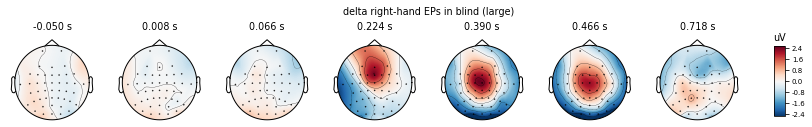

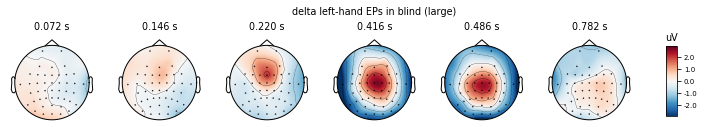

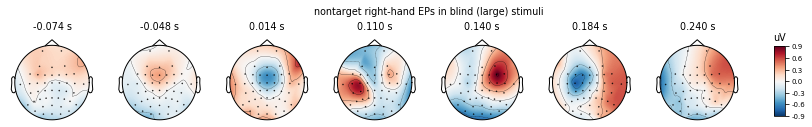

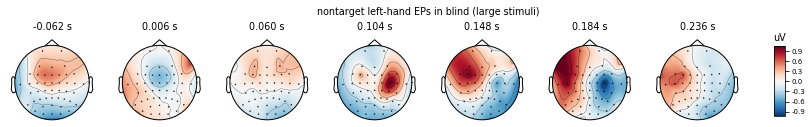

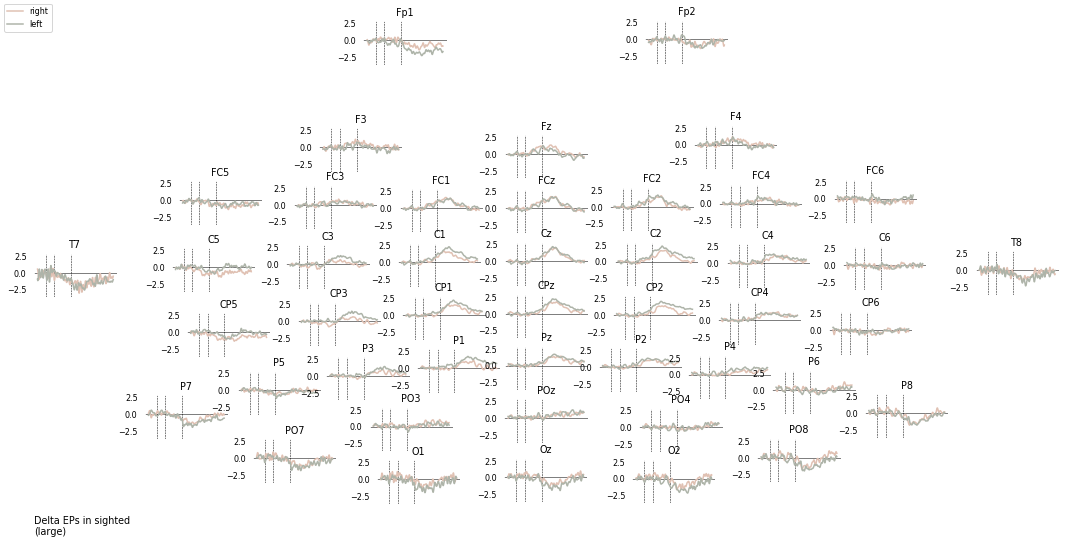

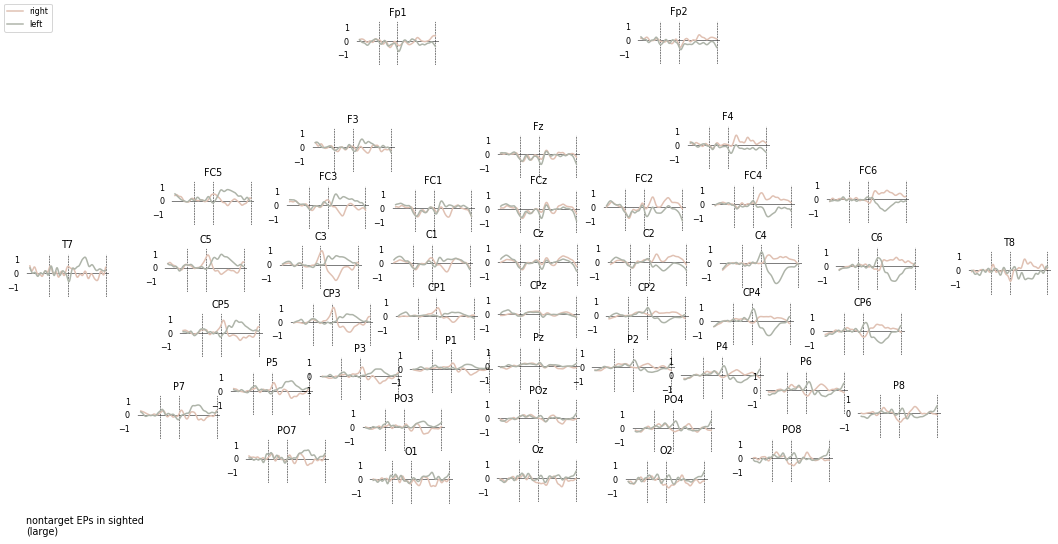

C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\User\Miniconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


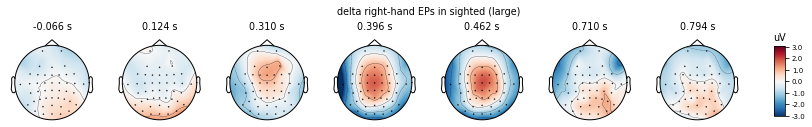

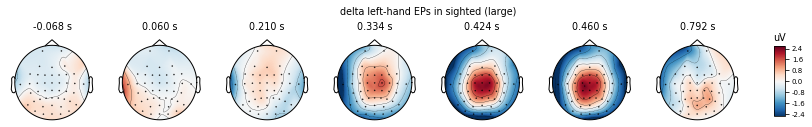

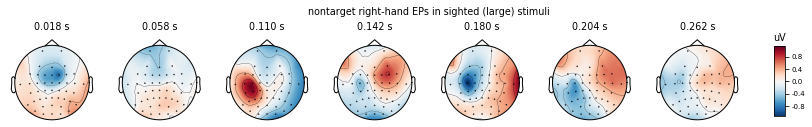

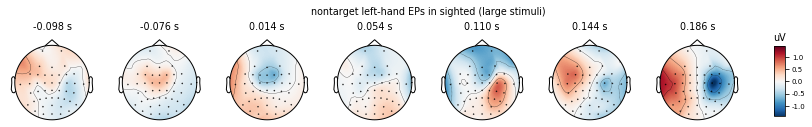

In [6]:
reg = 'large'
def hands(demography='blind', reg='large'):
    demographies = {'blind':1, 'sighted':0}
    # create evoked data
    subset_rh = ds.markup.loc[ (ds.markup['blind'] == demographies[demography]) &
                                (ds.markup['reg'] == reg) &
                                (ds.markup['finger'].isin([7,6,5,4]))]
    payload_rh = aps.subset(ds, subset_rh)

    subset_lh = ds.markup.loc[ (ds.markup['blind'] == demographies[demography]) &
                                (ds.markup['reg'] == reg) &
                                (ds.markup['finger'].isin([0,1,2,3]))]
    payload_lh = aps.subset(ds, subset_lh)
    
    # plot evoked data
    aps.plot_evoked_response(evoked_dict={ 'right': payload_rh['delta'],
                                           'left': payload_lh['delta']},
                            title=f'Delta EPs in {demography} \n({reg})')
    
    aps.plot_evoked_response(evoked_dict={'right': payload_rh['nontarget'].crop(tmax=0.3),
                                           'left': payload_lh['nontarget'].crop(tmax=0.3)},
                            title=f'nontarget EPs in {demography} \n({reg})')

    p = payload_rh['delta'].plot_topomap(times='peaks', scalings={'eeg':1}, show=False)
    p.suptitle(f'delta right-hand EPs in {demography} ({reg})')
    p.show()

    p = payload_lh['delta'].plot_topomap(times='peaks', scalings={'eeg':1}, show=False)
    p.suptitle(f'delta left-hand EPs in {demography} ({reg})')
    p.show()

    p = payload_rh['nontarget'].crop(tmax=0.3).plot_topomap(times='peaks', scalings={'eeg':1}, show=False)
    p.suptitle(f'nontarget right-hand EPs in {demography} ({reg}) stimuli')
    p.show()

    p = payload_lh['nontarget'].crop(tmax=0.3).plot_topomap(times='peaks', scalings={'eeg':1}, show=False)
    p.suptitle(f'nontarget left-hand EPs in {demography} ({reg} stimuli)')
    p.show()

hands(demography='blind')
hands(demography='sighted')

Compare grand average ERPs for blind subjects with congenital and acquired blindness. Not enough subjects to generate statistical power, so probably a separate study is needed. The literature on the differences is contradictory, as usual.

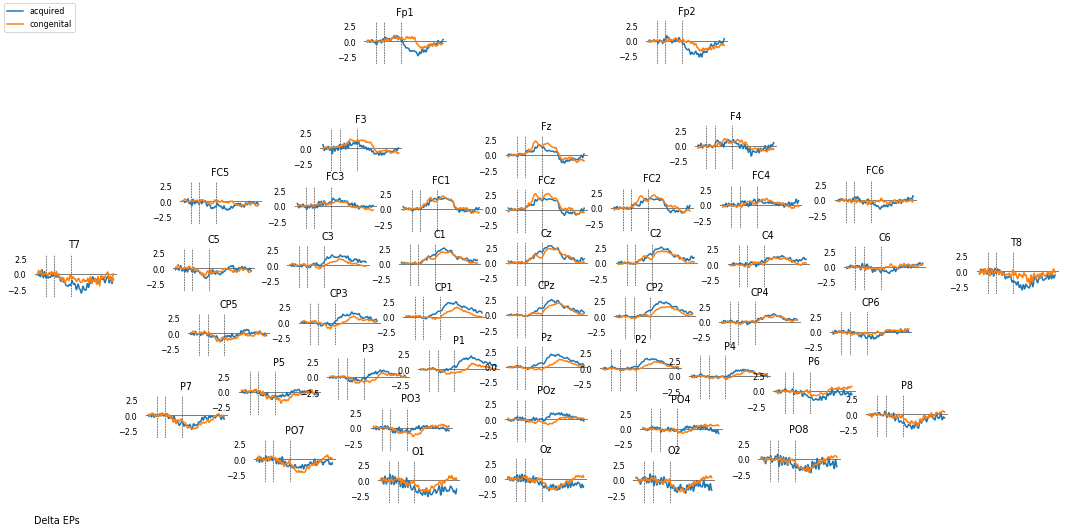

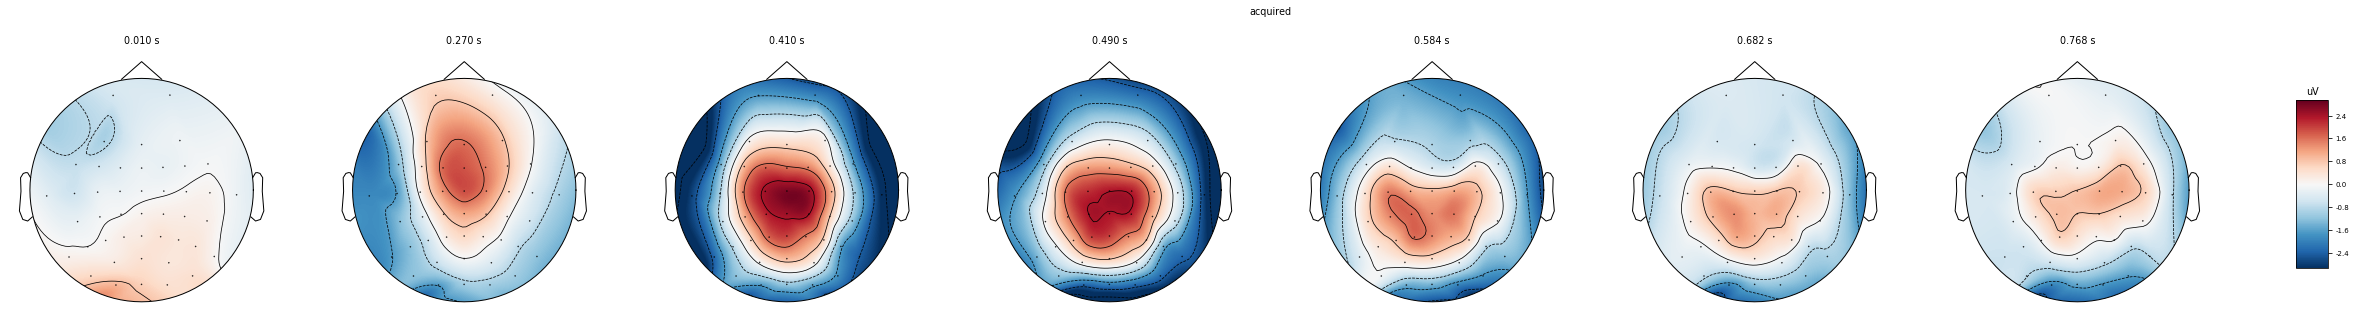

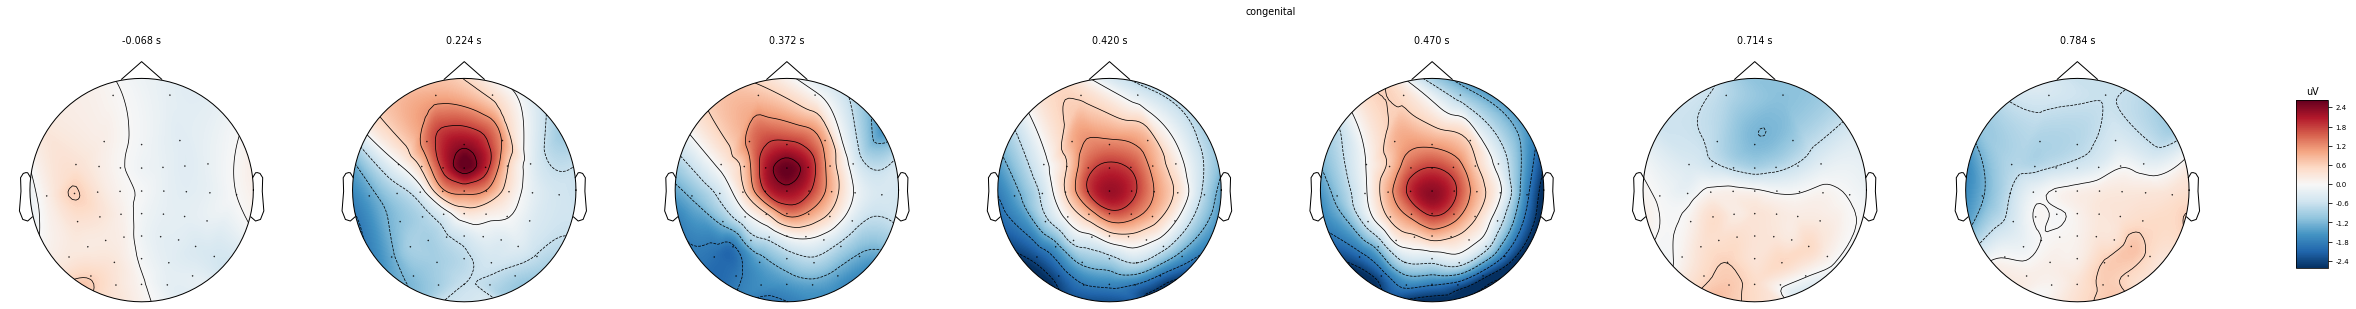

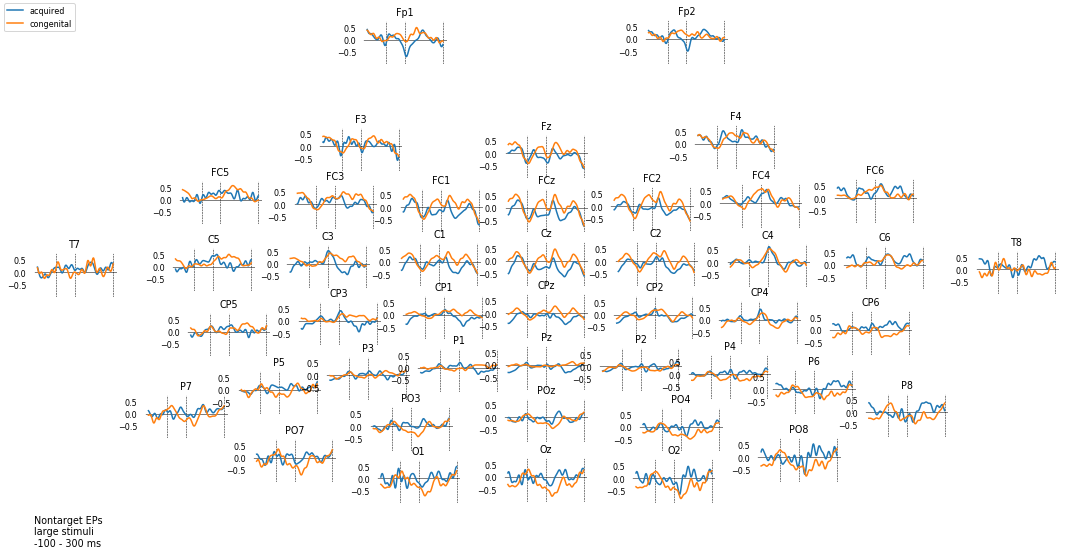

Text(0.5, 0.98, 'congenital')

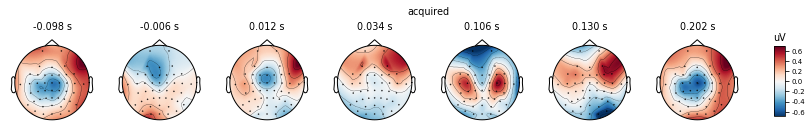

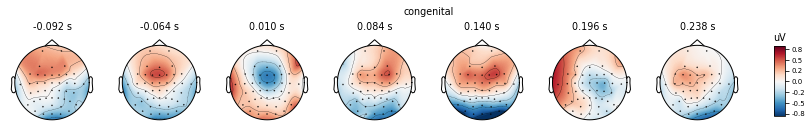

In [7]:
reg = 'large'
subset_cb = ds.markup.loc[ (ds.markup['blind'] == 1) &
                            (ds.markup['reg'] == reg) &
                            (ds.markup['blindness_age'] == 0)]
payload_cb = aps.subset(ds, subset_cb)

subset_ab = ds.markup.loc[ (ds.markup['blind'] == 1) &
                            (ds.markup['reg'] == reg) &
                            (ds.markup['blindness_age'] != 0)]
payload_ab = aps.subset(ds, subset_ab)

aps.plot_evoked_response(evoked_dict={ 'acquired': payload_ab['delta'],
                                       'congenital': payload_cb['delta']},
                        title=f'Delta EPs')
payload_ab['delta'].plot_topomap(times='peaks', scalings={'eeg':1}, show=False, contours=8, size=3)
plt.suptitle('acquired')
payload_cb['delta'].plot_topomap(times='peaks', scalings={'eeg':1}, show=False, contours=8, size=3)   
plt.suptitle('congenital')

aps.plot_evoked_response(evoked_dict={ 'acquired': payload_ab['nontarget'].crop(tmax=0.3),
                                       'congenital': payload_cb['nontarget'].crop(tmax=0.3)},
                                title=f'Nontarget EPs\n{reg} stimuli\n-100 - 300 ms')
payload_ab['nontarget'].plot_topomap(times='peaks', scalings={'eeg':1}, show=False)
plt.suptitle('acquired')
payload_cb['nontarget'].plot_topomap(times='peaks', scalings={'eeg':1}, show=False)   
plt.suptitle('congenital')

Plot first vs last target stimulus in the train for blind subjects.
This should account for the differences due to habituation, that is usually pronounced in visual BCIs - usually, the first target ERP in the stimulus train is larger, but this doesn't seem to be the case here.

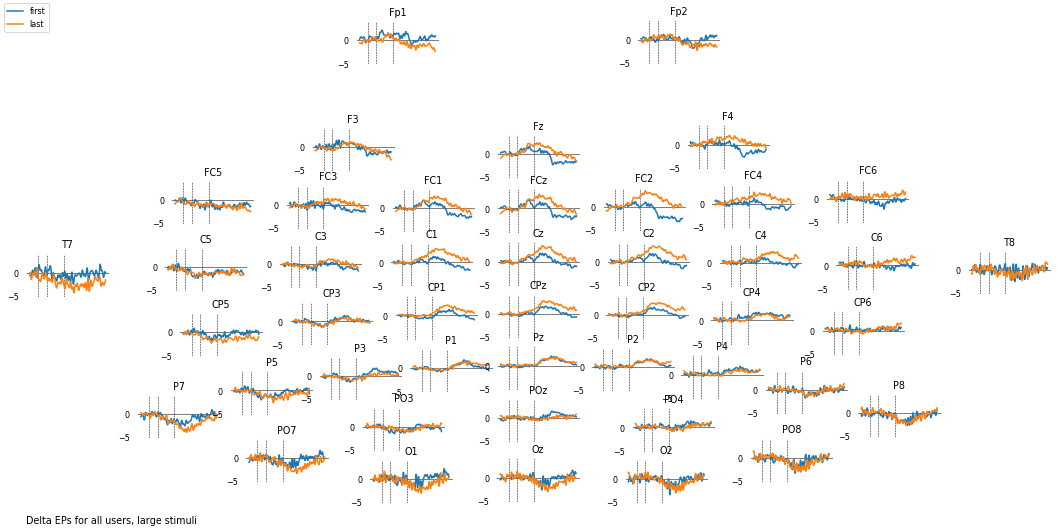

In [8]:
reg = 'large'
blind = 1
def plot(blind):
    subset_one = []
    subset_two = []
    for user in sorted(set(ds.markup.user[ds.markup.blind==blind])):
        for session_id in sorted(set(ds.markup.session_id)):
            ss2 = ds.markup.loc[        (ds.markup['reg'] == reg) &
                                        (ds.markup['is_target'] == 1) &
                                        (ds.markup['user'] == user) &
                                        (ds.markup.session_id == session_id)
                                ]
            subset_one.append(ss2.iloc[0])
            subset_two.append(ss2.iloc[9])

    ss_nt = ds.markup.loc[(ds.markup['reg'] == 'large') &
                          (ds.markup['is_target'] == 0)
                         ]

    subset_one = pd.DataFrame(subset_one)
    subset_one = pd.concat([subset_one, ss_nt])
    payload_one = aps.subset(ds, subset_one)

    subset_two = pd.DataFrame(subset_two)
    subset_two = pd.concat([subset_two, ss_nt])
    payload_two = aps.subset(ds, subset_two)


    aps.plot_evoked_response(evoked_dict={ 'first': payload_one['delta'],
                                           'last': payload_two['delta']},
                            title=f'Delta EPs for all users, {reg} stimuli')

plot(blind = 1)
    

Do the same for the sighted group.

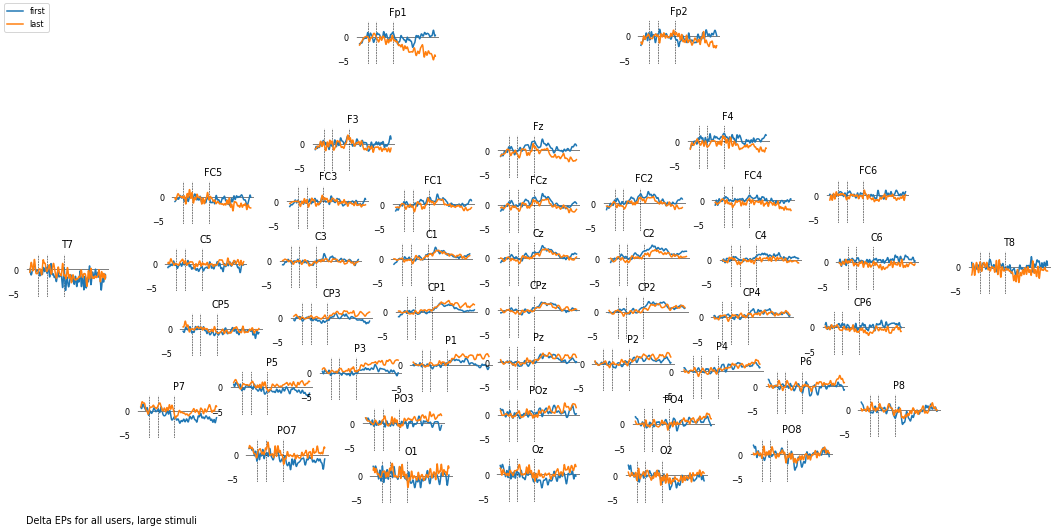

In [9]:
plot(blind = 0)

The choice of reference can significantly change the overall look of EEG data. This is an example of how would the data look with default reference (average earlobes) vs common average reference. While CAR is usually preferable for most imaging and machine learning applications, it's useful to take a look at other references, too.

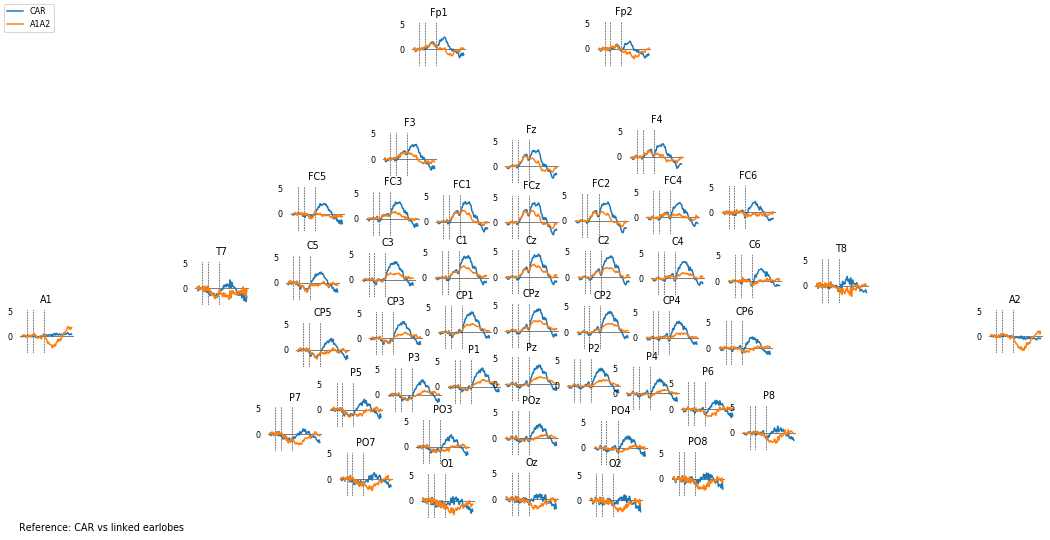

In [10]:
subset_rh = ds.markup.loc[ (ds.markup['blind'] == 1) &
                            (ds.markup['reg'] == 'large') &
                            (ds.markup['finger'].isin([7,6,5,4]))]
payload_rh = aps.subset(ds, subset_rh, drop_channels=['ecg'])['delta'].set_eeg_reference(['A1', 'A2'])
payload_rh2 = aps.subset(ds, subset_rh, drop_channels=['ecg'])['delta']

p = aps.plot_evoked_response({'CAR':payload_rh, 'A1A2':payload_rh2}, title='Reference: CAR vs linked earlobes')